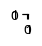

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# Get patient reconstruction accuracies

In [2]:
from joblib import Parallel, delayed
from functools import partial
MAXLENS={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}
def split_seq(seq, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    rec_seq = []
    i=0
    for name,length in max_lens.items():
        if length==0:
            continue
        rec_seq.append(seq[i:i+length].rstrip('X'))
        i+=length
    return rec_seq

def get_all_split(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df=df.copy()
    df.drop(columns=[x for x in df.columns if x.startswith('z_')], inplace=True)
    df[list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['true_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    df[list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['hat_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    return df
    
def get_cdr_acc(true, rec):
    if len(true)==len(rec):
        return np.mean([x==y for x,y in zip(true,rec)])
    elif len(true)>len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(true)-len(rec))*'X')])
    elif len(true)<len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(rec)-len(true))*'X')])
    else:
        return 0
        
def get_per_seq_acc(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df = df.copy()
    df = get_all_split(df, max_lens)
    true_cols=list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)
    rec_cols=list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)
    for true, rec in zip(true_cols, rec_cols):
        chain = true.rstrip('_true_rec')
        df[f'acc_{chain}'] =  df.apply(lambda x: get_cdr_acc(x[true], x[rec]), axis=1)
    return df

In [6]:
def glob_path(path, pattern):
    pt = glob.glob(f'{path}*{pattern}*.pt')[0]
    js = glob.glob(f'{path}*JSON_kwargs*.json')[0]
    return pt, js

In [10]:
garner = pd.read_csv('../data/OTS/garner_merged/garner_merged_41_42_43.csv')
francis = pd.concat([pd.read_csv(x) for x in glob.glob(f'../data/OTS/francis_covid_042/*')])

In [9]:
os_notrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/'
os_cstrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/'
ts_notrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC/'
ts_cstrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd/'
os_notrp = load_model_full(*glob_path(os_notrp_path, 'best'))
ts_notrp = load_model_full(*glob_path(ts_notrp_path, '4500'))
os_cstrp = load_model_full(*glob_path(os_cstrp_path, 'best'))
ts_cstrp = load_model_full(*glob_path(ts_cstrp_path, '4500'))

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
Best epoch: 19904
total: 0.3804485993018143
reconstruction: 0.3688316931078958
kld: 0.011616906193918503
triplet: 0.0
seq_accuracy: 0.9929980039596558
pos_accuracy: 0.9998289346694946
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
epoch: 4500
total: 0.7775099739190969
reconstruction: 0.24511546373418122
kld: 0.0
triplet: 0.0
BCE: 0.5323945055735589
seq_accuracy: 0.9910694360733032
pos_accuracy: 0.9997903108596802
auc: 0.7436
auc_01: 0.59057
auc_01_real: 0.22208
precision: 0.39935
recall: 0.43906
accuracy: 0.79582
AP: 0.35665
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
Best epoch: 19934
total: 0.07886607476881971
reconstruction: 0.05939108139774983
kld: 0.003005831211369365
triplet: 0.01646916461991662
seq_accuracy: 

In [ ]:
get_latent_df(os_notrp, garner)